In [49]:
import torch 
import torch.nn as nn
from torch.utils.data import  DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import os
from typing import Tuple, Dict, List
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
# https://medium.com/@karuneshu21/resnet-paper-walkthrough-b7f3bdba55f0
# https://arxiv.org/pdf/1512.03385.pdf
# https://medium.com/@karuneshu21/how-to-resnet-in-pytorch-9acb01f36cf5
torch.autograd.set_detect_anomaly(True)

In [50]:
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        # print(self.paths)
        self.classes, self.class_to_idx = self.find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)
        
    def find_classes(self,directory:str)->Tuple[list[str],dict[str,int]]:
        classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
        class_to_idx={cls_name: i for i, cls_name in enumerate(classes)}
        
        print(classes,class_to_idx)
        return classes,class_to_idx


In [51]:
class CustomDataTest():
    def __init__(self) -> None:

        self.train_dir = "C:\\Users\\Jakub Machura\\source\\repos\\UnderstandingDeepLearning\\data\\pizza_steak_sushi\\train"
        self.test_dir = "C:\\Users\\Jakub Machura\\source\\repos\\UnderstandingDeepLearning\\data\\pizza_steak_sushi\\test"
        """
            temp placement for of transform
        """
        self.train_transform=transforms.Compose([
            transforms.Resize(size=(224,224)),
            # transforms.TrivialAugmentWide(num_magnitude_bins=31),
            transforms.ToTensor()
        ])
    
        self.test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
        ])
    
        self.train_data =ImageFolderCustom(self.train_dir,transform=self.train_transform)
        self.test_data=ImageFolderCustom(self.test_dir,transform=self.test_transforms)
    
        """temp place for testing data"""    
        # Check for equality amongst our custom Dataset and ImageFolder Dataset
        # print((len(self.train_data) == len(data.train_data)) & (len(self.test_data) == len(data.test_data)))
        print(self.train_data.classes)
        # print(self.train_data.class_to_idx == data.train_data.class_to_idx)

        self.IntoDataLoaders()

    def IntoDataLoaders(self):
        BATCH_SIZE=32
        # NUM_WORKERS = os.cpu_count()
        NUM_WORKERS = 1

        # print(f"number of workers avalible {NUM_WORKERS}")
        self.train_dataloader= DataLoader(dataset=self.train_data, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                    #  num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

        self.test_dataloader = DataLoader(dataset=self.test_data, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    # num_workers=NUM_WORKERS, 
                                    shuffle=False) # don't usually need to shuffle testing data

        img,label=next(iter(self.test_dataloader))
        print(f"shape of custome dataloader img {img.shape} labels {label.shape}")

In [212]:
class Data():
    def __init__(self) -> None:
        from torchvision.transforms import ToTensor
        import numpy as np
        from torch.utils.data import Subset
        self.train_data_full =datasets.Food101(
            root='D:\PytorchData\data',
            split="train",
            download=False,
            transform=transforms.Compose(
                [
                    transforms.Resize((224,224)),
                    transforms.ToTensor()
                ]
            )
        )
        indices = list(range(len(self.train_data_full)))
        np.random.shuffle(indices)
        split_idx = int(len(indices) * 0.005)
        self.train_data = Subset(self.train_data_full, indices[:split_idx])

        self.test_data_full=datasets.Food101(
            root='D:\PytorchData\data',
            split="test",
            download=False,
            transform=transforms.Compose(
                [
                    transforms.Resize((224,224)),
                    transforms.ToTensor()
                ]
            )
        )
        
        indices = list(range(len(self.test_data_full)))
        np.random.shuffle(indices)
        split_idx = int(len(indices) * 0.005)
        self.test_data = Subset(self.test_data_full, indices[:split_idx])


        self.classes=self.train_data_full.classes
        self.ToDataloader()
    def ToDataloader(self):
        BATCH_SIZE=32
        self.train_dataloader=DataLoader(self.train_data,batch_size=BATCH_SIZE,shuffle=True)
        self.test_dataloader=DataLoader(self.test_data,batch_size=BATCH_SIZE,shuffle=False)
        

In [151]:
def train_step(model,optimizer,loss_fn,data:CustomDataTest):
    
    model.train()
    train_loss,train_acc=0,0

    for batch, (X,y) in enumerate(data.train_dataloader):
        y_logits=model(X)

        loss=loss_fn(y_logits,y)
        train_loss+=loss.item()


        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class=y_logits.argmax(dim=1)
        train_acc+=(y_pred_class==y).sum().item()/len(y_logits)

    train_loss=train_loss/len(data.train_dataloader)
    train_acc=train_acc/len(data.train_dataloader)
    return train_loss,train_acc

def test_step(model,loss_fn,data:CustomDataTest):
    model.eval()
    test_loss,test_acc=0,0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(data.test_dataloader):
            y_logits=model(X)
            
            loss=loss_fn(y_logits,y)
            test_loss+=loss.item()

            y_pred_class=y_logits.argmax(dim=1)
            test_acc+=(y_pred_class==y).sum().item()/len(y_logits)

    test_loss=test_loss/len(data.test_dataloader)
    test_acc=test_acc/len(data.test_dataloader)

    return test_loss,test_acc

def Totrain(model,data:CustomDataTest,optimizer,loss_fn,epochs:int):
    results={"train_loss":[],
             "train_acc" :[],
             "test_loss":[],
             "test_acc": []
             }
    
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model,optimizer,loss_fn,data)
        test_loss,test_acc=test_step(model,loss_fn,data)

                
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [214]:
def plot_loss_curves(results: Dict[str, List[float]]):
    import matplotlib.pyplot as plt
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.ylim([0,20])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # plt.show()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [127]:
# data=CustomDataTest()

# net=ResNet(3,len(data.train_data.classes))
# net_optimizer=torch.optim.SGD(net.parameters(),lr=0.1)
# net_loss_fn=nn.CrossEntropyLoss()
# res=Totrain(net,data,net_optimizer,net_loss_fn,2)


# x=torch.randn(32,3,224,224)
# print(f"out shape {y.shape}")



RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [32, 512, 7, 7]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!


In [208]:
class SimpleResNetblock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,identity_downsample=None) -> None:
        super(SimpleResNetblock,self).__init__()

        self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=stride)
        self.bn1=nn.BatchNorm2d(out_channels)
       
        self.conv2=nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1)
        self.bn2=nn.BatchNorm2d(out_channels)
       
        self.relu=nn.ReLU()

        self.identity_downsample=identity_downsample
    
    def forward(self,x):
        identity=x
        # print(f"identity shape x{identity.shape}")
        
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)

        x=self.conv2(x)
        x=self.bn2(x)

        if self.identity_downsample != None:
            identity=self.identity_downsample(identity)
            # print(f"identity shape after {identity.shape}")
            # print(f"x shape {x.shape}")

        x+=identity
        x=self.relu(x)
        # print(f"x shape {x.shape}")

        return x


In [209]:
class ResNet18(nn.Module):
    def __init__(self,block:SimpleResNetblock,img_channels,num_classes,block_num:list) -> None:
        super(ResNet18,self).__init__()
        
        self.in_channels=64

        self.conv1=nn.Conv2d(img_channels,64,kernel_size=7,stride=2,padding=3)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.layer2=self._make_layer(block,block_num[0],64,1)
        self.layer3=self._make_layer(block,block_num[1],128,2)
        self.layer4=self._make_layer(block,block_num[2],256,2)
        self.layer5=self._make_layer(block,block_num[3],512,2)

        

        self.avg=nn.AvgPool2d((1,1))
        self.fc=nn.Linear(512*7*7,num_classes)


    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)

        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)

        
        x=self.avg(x)
        # print(f"shape after avg {x.shape}")
        x=x.reshape(x.shape[0],-1)
        # print(f"shape after reshape {x.shape}")
        x=self.fc(x)
        # print(f"output shape {x.shape}")
        
        return x
    
    def _make_layer(self,block,num_blocks,out_channels,stride):
        identity_downsample=None
        layers=[]
        if stride!=1:
            identity_downsample=nn.Sequential(
                nn.Conv2d(self.in_channels,out_channels,1,stride,padding=0),
                nn.BatchNorm2d(out_channels)
            )
        layers.append(block(self.in_channels,out_channels=out_channels,stride=stride,identity_downsample=identity_downsample))
        self.in_channels=out_channels

        for i in range(num_blocks-1):
            layers.append(block(self.in_channels,out_channels=out_channels))

        return nn.Sequential(*layers)

len train_dataloader 384
len test_dataloader 128
in shape torch.Size([2, 3, 224, 224])
out shape torch.Size([2, 101])


 10%|█         | 1/10 [00:35<05:15, 35.07s/it]

Epoch: 1 | train_loss: 55.3413 | train_acc: 0.0214 | test_loss: 6858.0656 | test_acc: 0.0156


 20%|██        | 2/10 [01:07<04:28, 33.61s/it]

Epoch: 2 | train_loss: 11.4300 | train_acc: 0.0052 | test_loss: 5.5316 | test_acc: 0.0000


 30%|███       | 3/10 [01:40<03:52, 33.18s/it]

Epoch: 3 | train_loss: 5.8199 | train_acc: 0.0312 | test_loss: 5.6874 | test_acc: 0.0078


 40%|████      | 4/10 [02:13<03:18, 33.10s/it]

Epoch: 4 | train_loss: 5.2661 | train_acc: 0.0507 | test_loss: 5.5189 | test_acc: 0.0000


 50%|█████     | 5/10 [02:46<02:44, 32.97s/it]

Epoch: 5 | train_loss: 4.9648 | train_acc: 0.0507 | test_loss: 5.3233 | test_acc: 0.0000


 60%|██████    | 6/10 [03:19<02:12, 33.01s/it]

Epoch: 6 | train_loss: 4.8266 | train_acc: 0.0475 | test_loss: 7.9551 | test_acc: 0.0000


 70%|███████   | 7/10 [03:51<01:38, 32.95s/it]

Epoch: 7 | train_loss: 4.9739 | train_acc: 0.0409 | test_loss: 5.1539 | test_acc: 0.0078


 80%|████████  | 8/10 [04:24<01:05, 32.91s/it]

Epoch: 8 | train_loss: 4.5195 | train_acc: 0.0449 | test_loss: 5.0950 | test_acc: 0.0000


 90%|█████████ | 9/10 [04:57<00:32, 32.88s/it]

Epoch: 9 | train_loss: 4.3401 | train_acc: 0.0605 | test_loss: 5.1628 | test_acc: 0.0000


100%|██████████| 10/10 [05:28<00:00, 32.87s/it]

Epoch: 10 | train_loss: 4.4330 | train_acc: 0.0761 | test_loss: 5.0149 | test_acc: 0.0000


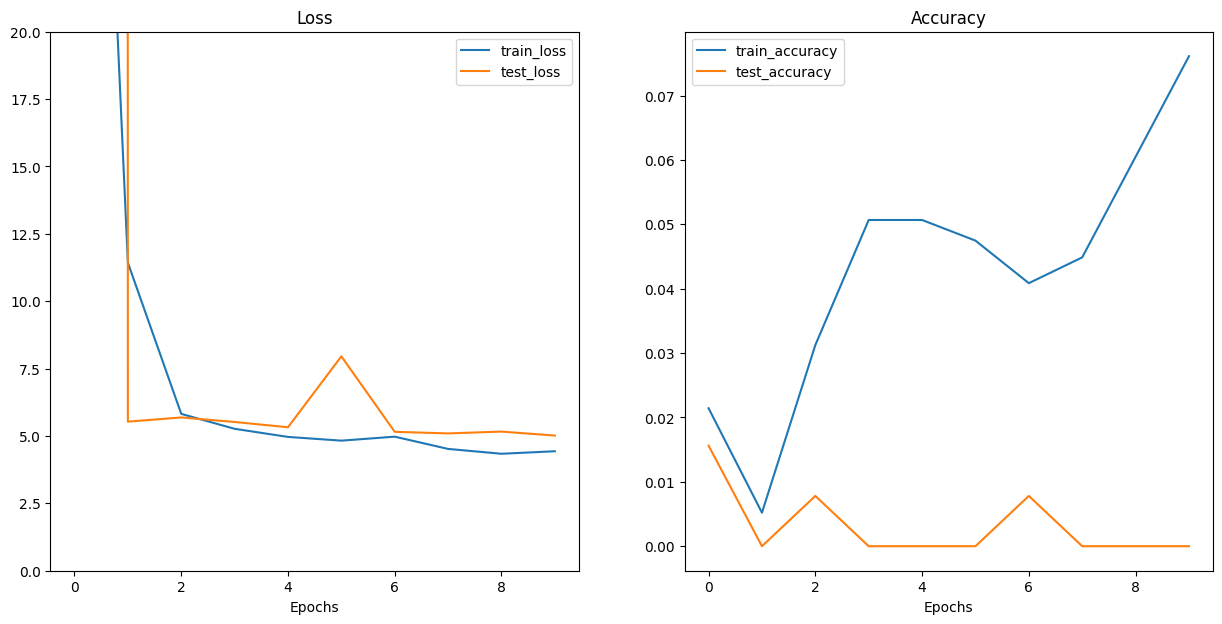

In [217]:
data=Data()
train_features_batch, train_labels_batch = next(iter(data.train_dataloader))
print(f"len train_dataloader {len(data.train_dataloader)*32}")
print(f"len test_dataloader {len(data.test_dataloader)*32}")



net=ResNet18(SimpleResNetblock,3,len(data.classes),[3,4,6,3])
x=torch.randn(2,3,224,224)
print(f"in shape {x.shape}")

y=net(x)
print(f"out shape {y.shape}")


net_optimizer=torch.optim.SGD(net.parameters(),lr=0.1)
net_loss_fn=nn.CrossEntropyLoss()
res=Totrain(net,data,net_optimizer,net_loss_fn,10)

plot_loss_curves(res)



